# Evaluation of CosmoFlow training

In [1]:
%pwd

'/global/u2/s/sfarrell/WorkAreas/benchmarks/cosmoflow-benchmark/notebooks'

In [2]:
import os
import sys
import yaml
import pickle

sys.path.append('..')

In [3]:
import sklearn
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [4]:
from models import get_model
from data.cosmo import construct_dataset
from utils.optimizers import get_optimizer

In [5]:
%matplotlib inline

In [6]:
plt.rcParams.update({'font.size': 14})

## Load the results

In [7]:
def load_config(result_dir):
    config_file = os.path.join(result_dir, 'config.pkl')
    with open(config_file, 'rb') as f:
        return pickle.load(f)

def load_history(result_dir):
    history_file = os.path.join(result_dir, 'history.csv')
    return pd.read_csv(history_file)

In [8]:
ls /global/cscratch1/sd/sfarrell/cosmoflow-benchmark/results

alt-cosmoflow-2020-03-05/   cosmoflow-v2-hpo-478158-0/
cosmoflow-2020-03-05/       cosmoflow-v2-hpo-478262-0/
cosmoflow-2020-03-08/       cosmoflow-v2-hpo-478263-0/
cosmoflow-2020-03-09/       cosmoflow-v2-hpo-478264-0/
cosmoflow-2020-03-11/       cosmoflow-v2-hpo-478265-0/
cosmoflow-2020-03-11-2/     cosmoflow-v2-hpo-478266-0/
cosmoflow-2020-03-11-3/     cosmoflow-v2-hpo-478267-0/
cosmoflow-2020-03-12/       cosmoflow-v2-hpo-478268-0/
cosmoflow-2020-03-18/       cosmoflow-v2-hpo-478269-0/
cosmoflow-2020-03-19/       cosmoflow-v2-hpo-478270-0/
cosmoflow-2020-03-20/       cosmoflow-v2-hpo-478271-0/
cosmoflow-2020-03-23-n256/  cosmoflow-v2-hpo-478272-0/
cosmoflow-2020-03-23-n512/  cosmoflow-v2-hpo-478273-0/
cosmoflow-2020-03-23-n64/   cosmoflow-v2-hpo-478274-0/
cosmoflow-2020-03-27/       cosmoflow-v2-hpo-478275-0/
cosmoflow-2020-03-29/       cosmoflow-v2-hpo-478276-0/
cosmoflow-2020-03-31/       cosmoflow-v2-hpo-478277-0/
cosmoflow-2020-04-13-n64/   cosmoflow-v2-hpo-478278-0/
cosmoflow-

In [9]:
#result_dir = os.path.expandvars(config['output_dir'])

# These have some kind of errors seemingly related to checkpoint resuming
#result_dir = '/global/cscratch1/sd/sfarrell/cosmoflow-benchmark/results/cosmoflow-2020-03-05'
#result_dir = '/global/cscratch1/sd/sfarrell/cosmoflow-benchmark/results/alt-cosmoflow-2020-03-05'

# Running 4-node with data-staging
#result_dir = '/global/cscratch1/sd/sfarrell/cosmoflow-benchmark/results/cosmoflow-2020-03-20'

# 8-node staging
#result_dir = '/global/cscratch1/sd/sfarrell/cosmoflow-benchmark/results/cosmoflow-2020-03-27'

# Cori CPU runs
#result_dir = '/global/cscratch1/sd/sfarrell/cosmoflow-benchmark/results/cosmoflow-2020-03-23-n512'

# Cori GPU, 16-node
result_dir = '/global/cscratch1/sd/sfarrell/cosmoflow-benchmark/results/cosmoflow-2020-04-27-n128'

In [10]:
ls -l $result_dir

total 2804340
-rw-rw---- 1 sfarrell sfarrell 44863784 Apr 28 08:12 checkpoint-001.h5
-rw-rw---- 1 sfarrell sfarrell 44863784 Apr 28 08:14 checkpoint-002.h5
-rw-rw---- 1 sfarrell sfarrell 44863784 Apr 28 08:16 checkpoint-003.h5
-rw-rw---- 1 sfarrell sfarrell 44863784 Apr 28 08:18 checkpoint-004.h5
-rw-rw---- 1 sfarrell sfarrell 44863784 Apr 28 08:20 checkpoint-005.h5
-rw-rw---- 1 sfarrell sfarrell 44863784 Apr 28 08:22 checkpoint-006.h5
-rw-rw---- 1 sfarrell sfarrell 44863784 Apr 28 08:24 checkpoint-007.h5
-rw-rw---- 1 sfarrell sfarrell 44863784 Apr 28 08:26 checkpoint-008.h5
-rw-rw---- 1 sfarrell sfarrell 44863784 Apr 28 08:28 checkpoint-009.h5
-rw-rw---- 1 sfarrell sfarrell 44863784 Apr 28 08:30 checkpoint-010.h5
-rw-rw---- 1 sfarrell sfarrell 44863784 Apr 28 08:32 checkpoint-011.h5
-rw-rw---- 1 sfarrell sfarrell 44863784 Apr 28 08:34 checkpoint-012.h5
-rw-rw---- 1 sfarrell sfarrell 44863784 Apr 28 08:36 checkpoint-013.h5
-rw-rw---- 1 sfarrell sfarrell 44863784 Apr 28 08:38 checkpoint

In [11]:
config = load_config(result_dir)
train_history = load_history(result_dir)

In [12]:
config

{'output_dir': '/global/cscratch1/sd/sfarrell/cosmoflow-benchmark/results/cosmoflow-2020-04-27-n128',
 'data': {'name': 'cosmo',
  'data_dir': '/tmp/sfarrell/cosmoflow-benchmark/data/cosmoUniverse_2019_05_4parE_tf',
  'n_train': 262144,
  'n_valid': 65536,
  'sample_shape': [128, 128, 128, 4],
  'batch_size': 4,
  'n_epochs': 64,
  'shard': True,
  'apply_log': True,
  'prefetch': 4,
  'staged_files': True},
 'model': {'name': 'cosmoflow',
  'input_shape': [128, 128, 128, 4],
  'target_size': 4,
  'conv_size': 32,
  'fc1_size': 128,
  'fc2_size': 64,
  'hidden_activation': 'LeakyReLU',
  'pooling_type': 'MaxPool3D',
  'dropout': 0.5},
 'optimizer': {'name': 'SGD',
  'lr': 0.01,
  'momentum': 0.9,
  'lr_scaling': 'none'},
 'train': {'loss': 'mse',
  'metrics': ['mae'],
  'lr_schedule': {32: 0.1},
  'early_stopping_patience': 8},
 'n_ranks': 128}

## View training history

In [13]:
train_history

,epoch,loss,lr,mean_absolute_error,time,val_loss,val_mean_absolute_error
0,0,0.228803,0.010,0.392180,178.491663,0.170774,0.331003
1,1,0.181048,0.010,0.342795,121.201626,0.167539,0.326981
2,2,0.171927,0.010,0.332524,115.147097,0.159563,0.316037
3,3,0.168473,0.010,0.328372,117.513010,0.139581,0.296642
4,4,0.158606,0.010,0.318494,115.626011,0.144733,0.302104
...,...,...,...,...,...,...,...
59,59,0.052312,0.001,0.176591,119.780977,0.033485,0.130132
60,60,0.052107,0.001,0.176136,119.794830,0.034789,0.132451
61,61,0.052135,0.001,0.176160,119.347185,0.033410,0.129494
62,62,0.052139,0.001,0.176150,119.477281,0.033519,0.130344


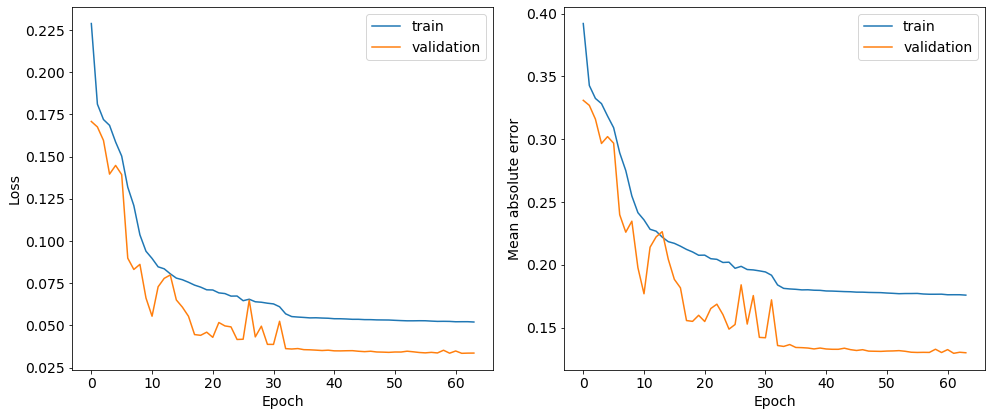

In [14]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(14, 6))

ax0.plot(train_history.loss, label='train')
ax0.plot(train_history.val_loss, label='validation')
ax0.set_xlabel('Epoch')
ax0.set_ylabel('Loss')
ax0.legend(loc=0)

ax1.plot(train_history.mean_absolute_error, label='train')
ax1.plot(train_history.val_mean_absolute_error, label='validation')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Mean absolute error')
ax1.legend(loc=0)

plt.tight_layout()

Text(0, 0.5, 'Learning rate')

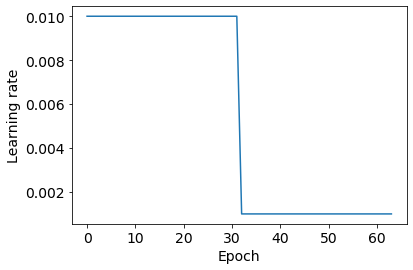

In [15]:
# Plot the learning rate
plt.figure()
plt.plot(train_history.lr)
plt.xlabel('Epoch')
plt.ylabel('Learning rate')

In [16]:
# Choose best epoch based on validation loss
best_epoch = train_history.epoch.loc[train_history.val_loss.idxmin()]
print('Best epoch:', best_epoch)

Best epoch: 61


In [17]:
train_history.loc[best_epoch]

epoch                       61.000000
loss                         0.052135
lr                           0.001000
mean_absolute_error          0.176160
time                       119.347185
val_loss                     0.033410
val_mean_absolute_error      0.129494
Name: 61, dtype: float64

## Reload the model

In [18]:
import models.cosmoflow

# Load the model checkpoint
checkpoint = os.path.join(result_dir, 'checkpoint-{epoch:03d}.h5'.format(epoch=best_epoch+1))
model = tf.keras.models.load_model(checkpoint)
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 128, 128, 128, 32) 1056      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 128, 32) 0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 64, 64, 64, 32)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 64, 64, 64, 64)    16448     
_________________________________________________________________
lea

## Evaluate the model on a test set

In [19]:
def convert_data_to_np(dataset, n_steps):
    iter_next = dataset.make_one_shot_iterator().get_next()
    with tf.Session() as sess:
        converted_data = [sess.run(iter_next) for i in range(n_steps)]
        return map(np.concatenate, zip(*converted_data))

def convert_labels_to_np(dataset, n_steps):
    iter_next = dataset.make_one_shot_iterator().get_next()
    with tf.Session() as sess:
        return np.concatenate([sess.run(iter_next)[1] for i in range(n_steps)])

In [20]:
n_test = 8192
data_config = config['data']
batch_size = 8
data_dir = '/global/cscratch1/sd/sfarrell/cosmoflow-benchmark/data/cosmoUniverse_2019_05_4parE_tf/test'

In [21]:
data_config

{'name': 'cosmo',
 'data_dir': '/tmp/sfarrell/cosmoflow-benchmark/data/cosmoUniverse_2019_05_4parE_tf',
 'n_train': 262144,
 'n_valid': 65536,
 'sample_shape': [128, 128, 128, 4],
 'batch_size': 4,
 'n_epochs': 64,
 'shard': True,
 'apply_log': True,
 'prefetch': 4,
 'staged_files': True}

In [22]:
# Construct the test dataset
test_data, n_test_steps = construct_dataset(data_dir, n_samples=n_test, batch_size=batch_size,
                                            n_epochs=1, sample_shape=data_config['sample_shape'],
                                            apply_log=data_config.get('apply_log', False),
                                            randomize_files=True)

In [23]:
%%time

# Apply the model to the test set
test_pred = model.predict(test_data, steps=n_test_steps, verbose=1)

1024/1024 [==============================] - 928s 906ms/step
CPU times: user 8min 34s, sys: 3min 43s, total: 12min 18s
Wall time: 15min 27s


In [24]:
%%time

# Pull out the test dataset labels - this is slow!
test_y = convert_labels_to_np(test_data, n_test_steps)

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
CPU times: user 7min 42s, sys: 3min 28s, total: 11min 10s
Wall time: 14min 40s


In [25]:
# Compute test set metrics
test_mse = sklearn.metrics.mean_squared_error(test_y, test_pred)
test_mae = sklearn.metrics.mean_absolute_error(test_y, test_pred)

In [26]:
print('Test set results for %i samples and %i variables:' % test_pred.shape)
print('MSE:', test_mse)
print('MAE:', test_mae)

Test set results for 8192 samples and 4 variables:
MSE: 0.034003384
MAE: 0.12966183


## Model analysis

Let's make some detailed plots to understand the performance of the model

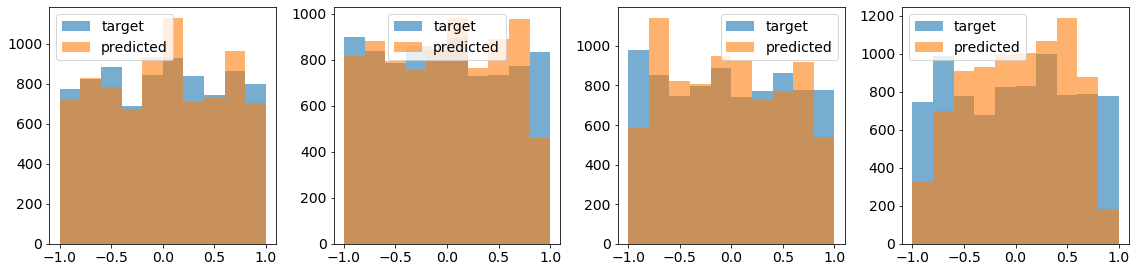

In [27]:
# 1D Distributions of cosmo params
fig, (ax0, ax1, ax2, ax3) = plt.subplots(ncols=4, figsize=(16, 4))

hist_args = dict(bins=10, range=(-1,1), alpha=0.6)
ax0.hist(test_y[:,0], label='target', **hist_args)
ax0.hist(test_pred[:,0], label='predicted', **hist_args)
ax0.legend(loc=0)
ax1.hist(test_y[:,1], label='target', **hist_args)
ax1.hist(test_pred[:,1], label='predicted', **hist_args)
ax1.legend(loc=0)
ax2.hist(test_y[:,2], label='target', **hist_args)
ax2.hist(test_pred[:,2], label='predicted', **hist_args)
ax2.legend(loc=0)
ax3.hist(test_y[:,3], label='target', **hist_args)
ax3.hist(test_pred[:,3], label='predicted', **hist_args)
ax3.legend(loc=0)
plt.tight_layout()

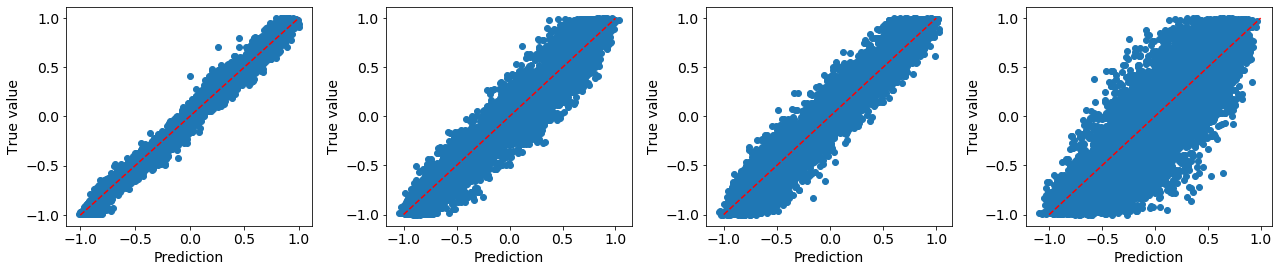

In [28]:
fig, axs = plt.subplots(ncols=4, figsize=(18, 4))

for i, ax in enumerate(axs):
    ax.scatter(test_pred[:,i], test_y[:,i])
    ax.plot([-1, 1], [-1, 1], 'r--')
    ax.set_xlabel('Prediction')
    ax.set_ylabel('True value')

plt.tight_layout()

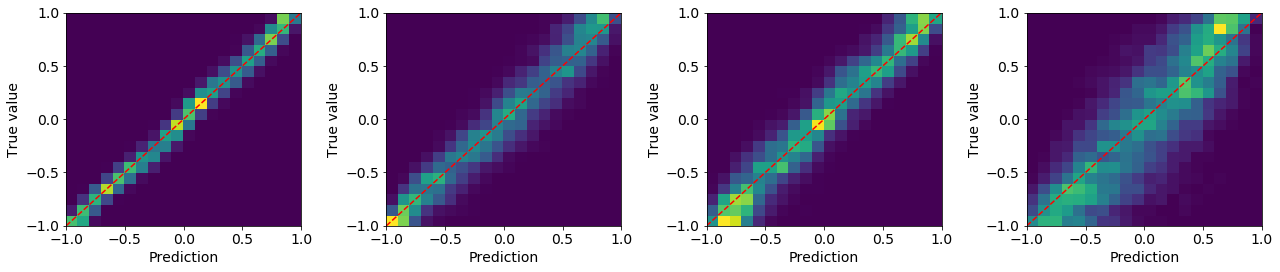

In [29]:
fig, axs = plt.subplots(ncols=4, figsize=(18, 4))

for i, ax in enumerate(axs):
    ax.hist2d(test_pred[:,i], test_y[:,i], bins=20, range=[[-1,1],[-1,1]])
    ax.plot([-1, 1], [-1, 1], 'r--')
    ax.set_xlabel('Prediction')
    ax.set_ylabel('True value')

plt.tight_layout()

## Discussion

The model is converging nicely at this scale with this dataset.
We still need to push it further and tune the hyperparameters for larger scale runs.